In [3]:
!mkdir -p data models

In [2]:
%%capture
!python -m pip install --upgrade pip
!pip install pytorch_lightning
!pip install --upgrade torch torchvision torchaudio
!pip install matplotlib

In [1]:
%%writefile models/vae.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialVAE(nn.Module):
    def __init__(self, in_channels=1, latent_channels=4):
        super().__init__()
        # Encoder: input (B,1,28,28)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),  # (B,32,14,14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),           # (B,64,7,7)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),          # (B,128,4,4)
            nn.ReLU(),
        )
        # Produce mean and logvar maps with 1x1 convolutions.
        self.mu_conv = nn.Conv2d(128, latent_channels, kernel_size=1)
        self.logvar_conv = nn.Conv2d(128, latent_channels, kernel_size=1)
        
        # Decoder: from latent (B, latent_channels, 4, 4) to reconstructed image (B,1,28,28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 128, kernel_size=3, stride=2, padding=1),  # (B,128,7,7) [output_padding may be 0]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B,64,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # (B,32,28,28)
            nn.ReLU(),
            nn.Conv2d(32, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        # Save the latent shape so that the diffusion model knows what to expect.
        self.latent_shape = (latent_channels, 4, 4)
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_conv(h)
        logvar = self.logvar_conv(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

Overwriting models/vae.py


In [ ]:
%%writefile unet.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, timesteps):
        device = timesteps.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(32, in_channels)
        self.norm2 = nn.GroupNorm(32, out_channels)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        t_emb = self.time_mlp(t)[:, :, None, None]
        h = h + t_emb
        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.residual_conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(32, channels)
        self.q = nn.Conv2d(channels, channels, kernel_size=1)
        self.k = nn.Conv2d(channels, channels, kernel_size=1)
        self.v = nn.Conv2d(channels, channels, kernel_size=1)
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        b, c, h, w = x.shape
        x_norm = self.norm(x)
        q = self.q(x_norm).reshape(b, c, -1).permute(0, 2, 1)
        k = self.k(x_norm).reshape(b, c, -1)
        v = self.v(x_norm).reshape(b, c, -1).permute(0, 2, 1)
        attn = torch.bmm(q, k) * (c ** -0.5)
        attn = torch.softmax(attn, dim=-1)
        out = torch.bmm(attn, v).permute(0, 2, 1).reshape(b, c, h, w)
        return x + self.proj_out(out)

class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(channels, channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, num_res_blocks, use_attn=False):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResBlock(in_channels if i == 0 else out_channels, out_channels, time_emb_dim)
            for i in range(num_res_blocks)
        ])
        self.use_attn = use_attn
        if use_attn:
            self.attn = AttentionBlock(out_channels)
        self.downsample = Downsample(out_channels)

    def forward(self, x, t):
        skip_connections = []
        for block in self.res_blocks:
            x = block(x, t)
            skip_connections.append(x)
        if self.use_attn:
            x = self.attn(x)
        x_down = self.downsample(x)
        return x_down, skip_connections

def center_crop(x, target_shape):
    _, _, h, w = x.shape
    th, tw = target_shape
    start_h = (h - th) // 2
    start_w = (w - tw) // 2
    return x[:, :, start_h:start_h+th, start_w:start_w+tw]

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, num_res_blocks, use_attn=False):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=4, stride=2, padding=1)
        self.res_blocks = nn.ModuleList([
            ResBlock(in_channels + out_channels if i == 0 else out_channels, out_channels, time_emb_dim)
            for i in range(num_res_blocks)
        ])
        self.use_attn = use_attn
        if use_attn:
            self.attn = AttentionBlock(out_channels)

    def forward(self, x, skip_connections, t):
        x = self.upsample(x)
        skip = skip_connections.pop()  # one skip connection per block
        if x.shape[2:] != skip.shape[2:]:
            x = center_crop(x, skip.shape[2:])
        x = torch.cat([x, skip], dim=1)
        for block in self.res_blocks:
            x = block(x, t)
        if self.use_attn:
            x = self.attn(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=64,
                 channel_mults=(1, 2, 4), num_res_blocks=2, time_emb_dim=256,
                 attn_resolutions=None):
        super().__init__()
        if attn_resolutions is None:
            attn_resolutions = []

        self.time_embedding = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        self.initial_conv = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        self.down_blocks = nn.ModuleList()
        in_ch = base_channels
        for i, mult in enumerate(channel_mults):
            out_ch = base_channels * mult
            use_attn = (i in attn_resolutions)
            self.down_blocks.append(DownBlock(in_ch, out_ch, time_emb_dim, num_res_blocks, use_attn))
            in_ch = out_ch

        self.mid_block1 = ResBlock(in_ch, in_ch, time_emb_dim)
        self.mid_attn = AttentionBlock(in_ch)
        self.mid_block2 = ResBlock(in_ch, in_ch, time_emb_dim)

        self.up_blocks = nn.ModuleList()
        for i, mult in enumerate(reversed(channel_mults)):
            out_ch = base_channels * mult
            use_attn = ((len(channel_mults) - 1 - i) in attn_resolutions)
            self.up_blocks.append(UpBlock(in_ch, out_ch, time_emb_dim, num_res_blocks, use_attn))
            in_ch = out_ch

        self.final_norm = nn.GroupNorm(32, in_ch)
        self.final_act = nn.SiLU()
        self.final_conv = nn.Conv2d(in_ch, out_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        t = t.to(x.device)
        t_emb = self.time_embedding(t)
        x = self.initial_conv(x)
        skip_connections_all = []
        for block in self.down_blocks:
            x, skip_connections = block(x, t_emb)
            skip_connections_all.append(skip_connections)
        x = self.mid_block1(x, t_emb)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t_emb)
        for block in self.up_blocks:
            skip_connections = skip_connections_all.pop()
            x = block(x, skip_connections, t_emb)
        x = self.final_norm(x)
        x = self.final_act(x)
        return self.final_conv(x)


In [3]:
%%writefile latent_diffusion.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

from unet import UNet

class LatentDiffusionModel(pl.LightningModule):
    def __init__(self, vae, T=1000, beta_start=1e-4, beta_end=0.02, lr=1e-3):
        super().__init__()
        self.vae = vae
        # Freeze VAE parameters.
        self.vae.eval()
        for param in self.vae.parameters():
            param.requires_grad = False

        latent_channels = self.vae.latent_shape[0]
        self.unet = UNet(
            in_channels=latent_channels,
            out_channels=latent_channels,
            base_channels=64,
            channel_mults=(1, 2, 4),
            num_res_blocks=2,
            time_emb_dim=256,
            attn_resolutions=[]
        )
        self.T = T
        self.lr = lr

        beta = torch.linspace(beta_start, beta_end, T)
        alpha = 1.0 - beta
        alpha_bar = torch.cumprod(alpha, dim=0)
        self.register_buffer("beta", beta)
        self.register_buffer("alpha", alpha)
        self.register_buffer("alpha_bar", alpha_bar)
        self.register_buffer("sqrt_alpha_bar", torch.sqrt(alpha_bar))
        self.register_buffer("sqrt_one_minus_alpha_bar", torch.sqrt(1 - alpha_bar))

    def forward(self, z, t):
        return self.unet(z, t)

    def training_step(self, batch, batch_idx):
        x, _ = batch  # x: (B,1,28,28)
        with torch.no_grad():
            mu, logvar = self.vae.encode(x)
            z = self.vae.reparameterize(mu, logvar)
            # z is already spatial (B, latent_channels, H, W)
        B = z.size(0)
        t = torch.randint(0, self.T, (B,), device=z.device)
        sqrt_alpha_bar_t = self.sqrt_alpha_bar[t].view(B, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bar[t].view(B, 1, 1, 1)
        noise = torch.randn_like(z)
        z_noisy = sqrt_alpha_bar_t * z + sqrt_one_minus_alpha_bar_t * noise
        pred_noise = self(z_noisy, t)
        loss = F.mse_loss(pred_noise, noise)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.unet.parameters(), lr=self.lr)

    @torch.no_grad()
    def sample_ddim(self, n_samples, ddim_steps=None, eta=0.0):
        device = self.device
        if ddim_steps is None:
            ddim_steps = self.T
            step_size = 1
        else:
            step_size = self.T // ddim_steps

        latent_shape = self.vae.latent_shape
        z = torch.randn(n_samples, *latent_shape, device=device)
        for i in range(self.T - 1, -1, -step_size):
            t = torch.full((n_samples,), i, device=device, dtype=torch.long)
            eps = self(z, t)
            sqrt_alpha_bar_t = self.sqrt_alpha_bar[i].view(1, 1, 1, 1)
            sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bar[i].view(1, 1, 1, 1)
            z0_pred = (z - sqrt_one_minus_alpha_bar_t * eps) / sqrt_alpha_bar_t
            t_prev = max(i - step_size, 0)
            sqrt_alpha_bar_t_prev = self.sqrt_alpha_bar[t_prev].view(1, 1, 1, 1)
            sqrt_one_minus_alpha_bar_t_prev = self.sqrt_one_minus_alpha_bar[t_prev].view(1, 1, 1, 1)
            z = sqrt_alpha_bar_t_prev * z0_pred + sqrt_one_minus_alpha_bar_t_prev * eps
        x_recon = self.vae.decode(z)
        return x_recon

    @torch.no_grad()
    def sample_ddpm(self, n_samples):
        device = self.device
        latent_shape = self.vae.latent_shape
        z = torch.randn(n_samples, *latent_shape, device=device)
        for i in range(self.T - 1, -1, -1):
            t = torch.full((n_samples,), i, device=device, dtype=torch.long)
            eps = self(z, t)
            sqrt_alpha_bar_t = self.sqrt_alpha_bar[i].view(1, 1, 1, 1)
            sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bar[i].view(1, 1, 1, 1)
            z0_pred = (z - sqrt_one_minus_alpha_bar_t * eps) / sqrt_alpha_bar_t
            if i > 0:
                noise = torch.randn_like(z)
                beta_t = self.beta[i].view(1, 1, 1, 1)
                alpha_t = self.alpha[i].view(1, 1, 1, 1)
                z = (1.0 / torch.sqrt(alpha_t)) * (z - (beta_t / torch.sqrt(1 - self.alpha_bar[i].view(1, 1, 1, 1))) * eps) + torch.sqrt(beta_t) * noise
            else:
                z = z0_pred
        x_recon = self.vae.decode(z)
        return x_recon


Overwriting latent_diffusion.py


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | vae  | SpatialVAE | 190 K  | train
--------------------------------------------
190 K     Trainable params
0         Non-trainable params
190 K     Total params
0.764     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


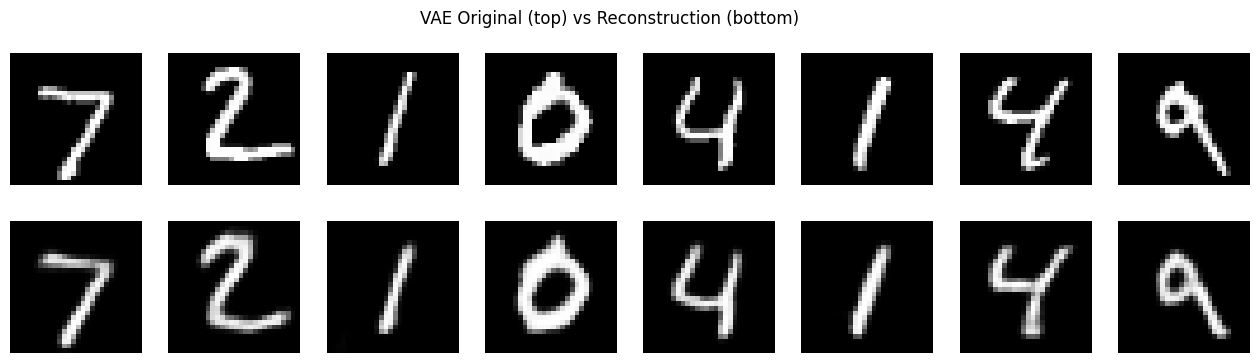

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | vae  | SpatialVAE | 190 K  | eval 
1 | unet | UNet       | 13.9 M | train
--------------------------------------------
13.9 M    Trainable params
190 K     Non-trainable params
14.1 M    Total params
56.412    Total estimated model params size (MB)
165       Modules in train mode
19        Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


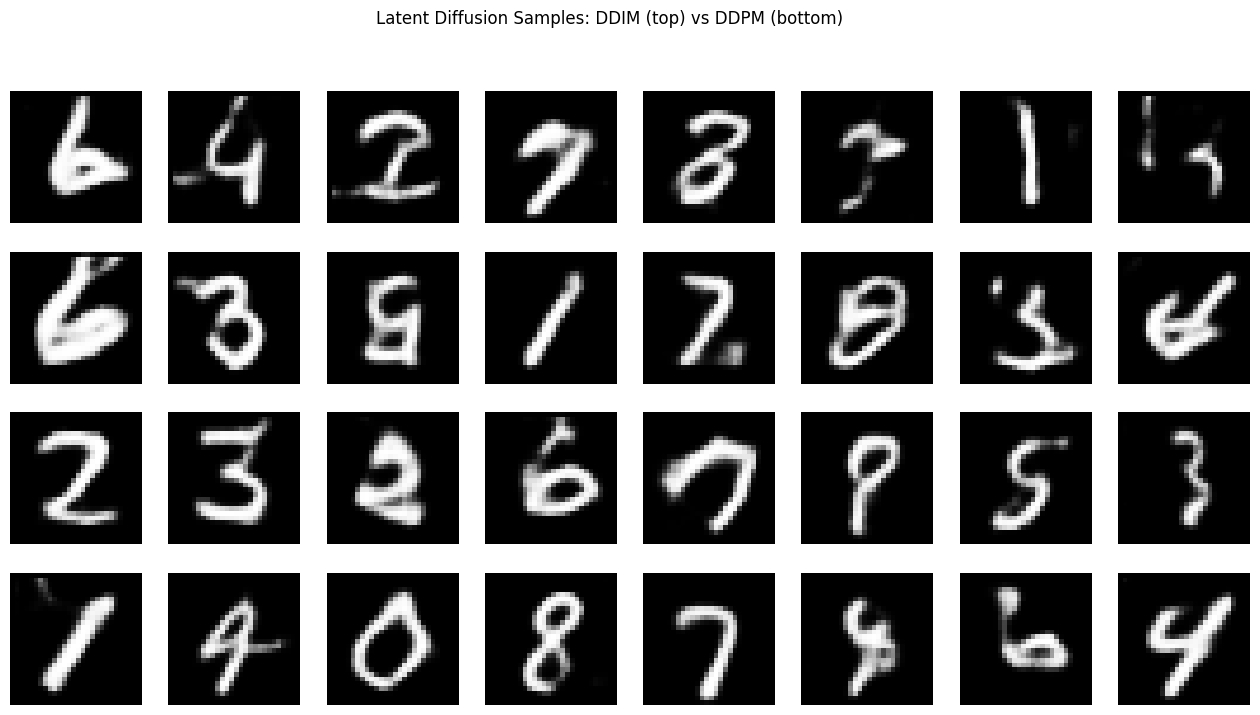

In [5]:
import torch
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

from models.vae import SpatialVAE
from latent_diffusion import LatentDiffusionModel

transform = transforms.Compose([
    transforms.ToTensor(),
])
mnist_full = datasets.MNIST(root='data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transform)
train_size = int(0.8 * len(mnist_full))
val_size = len(mnist_full) - train_size
mnist_train, mnist_val = random_split(mnist_full, [train_size, val_size])
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(mnist_val, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=4)

vae_model = SpatialVAE(in_channels=1, latent_channels=4)

class LitVAE(pl.LightningModule):
    def __init__(self, vae, lr=1e-3):
        super().__init__()
        self.vae = vae
        self.lr = lr

    def forward(self, x):
        return self.vae(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_recon, mu, logvar = self.vae(x)
        recon_loss = torch.nn.functional.binary_cross_entropy(x_recon, x, reduction='sum') / x.size(0)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        loss = recon_loss + kl_loss
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

lit_vae = LitVAE(vae_model, lr=1e-3)
trainer = pl.Trainer(max_epochs=30, accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
trainer.fit(lit_vae, train_loader, val_loader)

# visualize VAE reconstructions.
vae_model.eval()
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x_recon, _, _ = vae_model(x)
x = x.cpu()
x_recon = x_recon.cpu()

n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(x[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(2, n, i+1+n)
    plt.imshow(x_recon[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle('VAE Original (top) vs Reconstruction (bottom)')
plt.show()

# initialize and train the latent diffusion model.
latent_diffusion = LatentDiffusionModel(vae=vae_model, T=1000, lr=1e-3)
trainer = pl.Trainer(max_epochs=50, accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
trainer.fit(latent_diffusion, train_loader, val_loader)

# generate samples using DDIM and DDPM.
latent_diffusion.eval()
with torch.no_grad():
    samples_ddim = latent_diffusion.sample_ddim(n_samples=16, ddim_steps=50)
    samples_ddpm = latent_diffusion.sample_ddpm(n_samples=16)
samples_ddim = samples_ddim.cpu()
samples_ddpm = samples_ddpm.cpu()

plt.figure(figsize=(16, 8))
for i in range(16):
    plt.subplot(4, 8, i+1)
    plt.imshow(samples_ddim[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(4, 8, i+1+16)
    plt.imshow(samples_ddpm[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle('Latent Diffusion Samples: DDIM (top) vs DDPM (bottom)')
plt.show()